# Chapter 15: Processing Sequences Using RNNs and CNNs

In [1]:
import numpy as np
import os
import sklearn
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Forecasting Time series

### Generate dataset

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

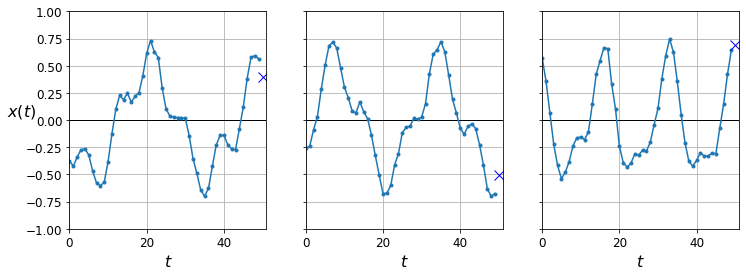

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
# save_fig("time_series_plot")
plt.show()

### Baseline metrics

#### Naive

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

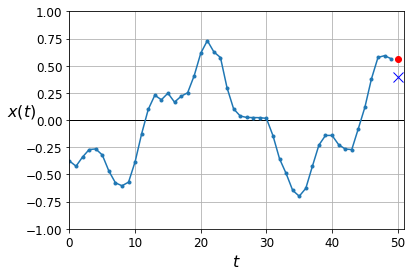

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Fully connected network: linear

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 587us/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 587us/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 601us/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 697us/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 564us/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 564us/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 564us/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 555us/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 555us/step - loss: 0.0063 

In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 371us/step - loss: 0.0042


0.004168087150901556

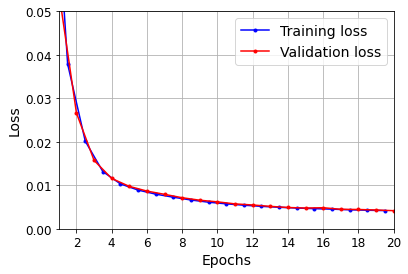

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

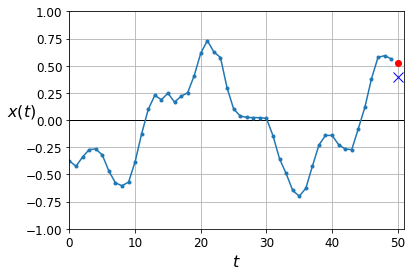

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Implementing a Simple RNN

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0117 - val_loss: 0.0110

### Deep RNNs

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0035 - val_lo

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029


0.002910564187914133

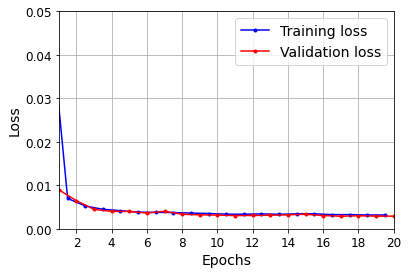

In [16]:
plot_learning_curves(history.history["loss"], history.history['val_loss'])
plt.show()

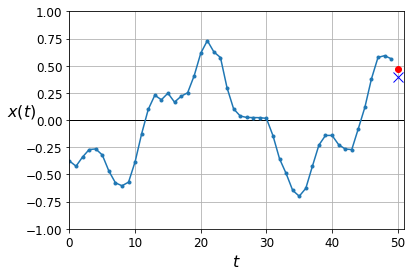

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Replace last SimpleRNN layer with Dense layer

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - ETA: 0s - loss: 0.003 - 2s 8ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0

In [19]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0026


0.002623623004183173

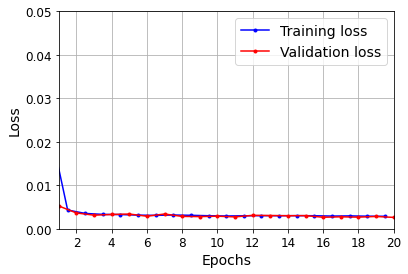

In [20]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

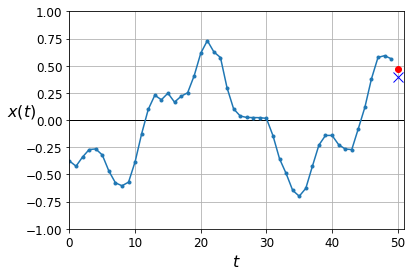

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show()

### Forecasting Several Time Steps Ahead

In [22]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [23]:
Y_pred.shape

(1, 10, 1)

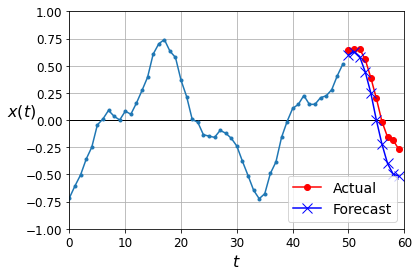

In [24]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
# save_fig("forecast_ahead_plot")
plt.show()

In [25]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [26]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [27]:
Y_pred.shape

(2000, 10)

In [28]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510857

#### Linear model

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 972us/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 624us/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 624us/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 619us/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 621us/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 622us/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 621us/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 615us/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 619us/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 628us/step - loss: 0.022

#### RNN that predicts next 10 values

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0118 - val_loss: 0.01

In [31]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

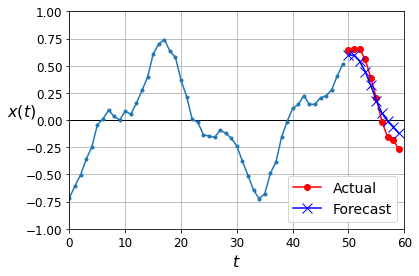

In [32]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Create an RNN that predicts the next 10 steps at each time step. 

* Instead of forecasting time steps 50 to 59 based on time steps 0 to 49
    * Forecast time steps 1 to 10 at time step 0
    * Then time steps 2 to 11 at time step 1, and so on
    * Finally it will forecast time steps 50 to 59 at the last time step. 
    
Causal model: when it makes predictions at any time step, it can only see past time steps.

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [34]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0367 - val_last_time_step_mse: 0.0267
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0339 - last_time_step_mse: 0.0228 - val_loss: 0.0308 - val_last_time_step_mse: 0.0186
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0297 - last_time_step_mse: 0.0186 - val_loss: 0.0279 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0278 - last_time_step_mse: 0.0163 - val_loss: 0.0268 - val_last_time_step_mse: 0.0167
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0257 - last_time_step_mse: 0.0130 - val_loss: 0.0219 - val_last_time_step_mse: 0.0085
Epoch 7/20
219/219 [========

In [36]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

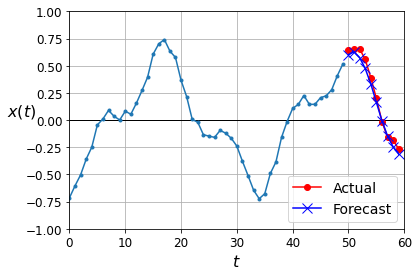

In [37]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Handling Long Sequences

### Deep RNN with Batch Norm

#### This is to show that Batch Norm doesn't work well with RNNs

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [========

### Deep RNN with Layer Norm

In [39]:
from tensorflow.keras.layers import LayerNormalization

In [40]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 22ms/step - loss: 0.2891 - last_time_step_mse: 0.2889 - val_loss: 0.0747 - val_last_time_step_mse: 0.0684
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0697 - last_time_step_mse: 0.0604 - val_loss: 0.0596 - val_last_time_step_mse: 0.0486
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0586 - last_time_step_mse: 0.0489 - val_loss: 0.0531 - val_last_time_step_mse: 0.0417
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0521 - last_time_step_mse: 0.0412 - val_loss: 0.0474 - val_last_time_step_mse: 0.0354
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0467 - last_time_step_mse: 0.0349 - val_loss: 0.0431 - val_last_time_step_mse: 0.0307
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0424 - last_time_step_mse: 0.0294 - val_loss: 0.0382 - val_last_time_step_mse: 0.0247
Epoch 7/20
219/219 [==

### LSTM

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 19ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [46]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788683116436005, 0.008560800924897194]

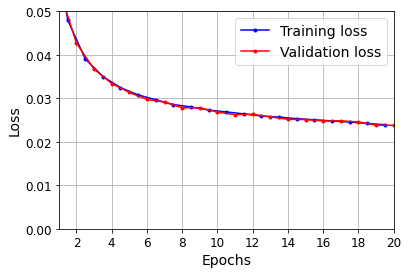

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [48]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

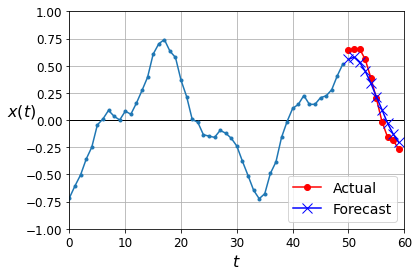

In [49]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### GRUs

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 21ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

In [52]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262805968523026]

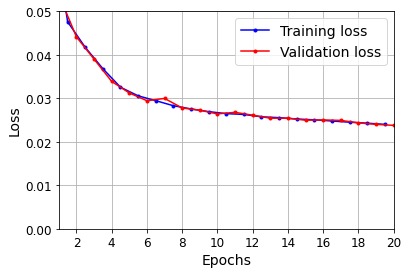

In [53]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [54]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

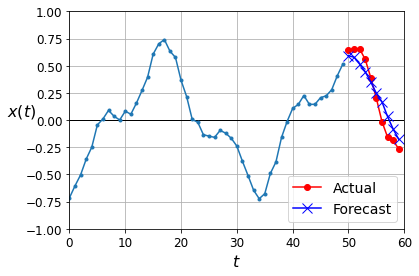

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### Using 1D Convolutional Layers to Process Sequences

In [56]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 6s 13ms/step - loss: 0.0908 - last_time_step_mse: 0.0845 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0437 - last_time_step_mse: 0.0357 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0356 - last_time_step_mse: 0.0282 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0293 - last_time_step_mse: 0.0201 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0256 - last_time_step_mse: 0.0152 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0239 - last_time_step_mse: 0.0129 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [==

#### Wavenet

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0981 - last_time_step_mse: 0.0891 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0340 - last_time_step_mse: 0.0212 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0291 - last_time_step_mse: 0.0163 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0265 - last_time_step_mse: 0.0141 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0251 - last_time_step_mse: 0.0129 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0242 - last_time_step_mse: 0.0121 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

In [58]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0188 - last_time_step_mse: 0.0072


[0.01883639208972454, 0.00721160601824522]

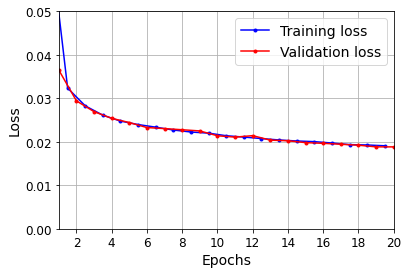

In [59]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [60]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

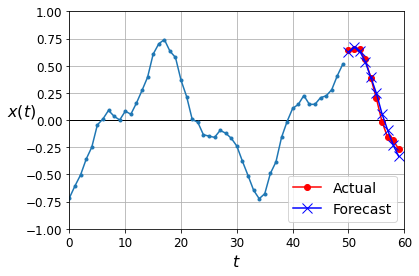

In [61]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()